# Data Science with Protest Responses

### Kalonji Harrington

In modern democracies, protests are seen as a healthy and necessary political act to secure freedom and justice against political powers. Most liberal democracies offer protections for protestors and significant media coverage is often given to large protests.

How states should respond to protests is a very contreversial topic however, especially when violence is involved. Authoritarian states are often condemned for abuse of violent tactics to suppress protests. Arresting, beating, or killing protestors is seen as a symbol of tyranny and broadcast as a critique of government power. 

But how often do such responses happen? Does this vary over time? How much more do authoritarian regimes commit violence against protestors over liberal democracies? The answers to these questions all paint a picture of how and when violent responses to protests and give a taste of the political climate over time and across different forms of government. 

I will attempt to answer these questions and others like them using data from the Mass Mobilization Project. This dataset contains data about protests (gatherings of 50 or more people for political action). 

These sources should provide valuable insights into the trends around violent government responses to protests. And in analyzing these potential trends, I will detail the process of traversing the data science pipeline, from data collection to results interpretation. So without further ado, let's begin our inquiry. 

## Protest Data Collection

The first step to performing analysis on any data is to first collect the data. The data I am using for this project is hosted on Harvard's dataverse respository at https://dataverse.harvard.edu/dataverse/MMdata. Documentation on what is included in the dataset and what each field represents can be found in the user manual at https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/HTTWYL/TJJZNG&version=5.0.

In brief, this dataset includes protest data for gatherings greater than 50 people across 162 countries. Some key data points collected include:
* When and where the protest occurred
* An estimate of the number of participants
* Whether the protesters engaged in violence
* The response (or lack therof) from the state

### pyDataverse

The Dataverse repository system has a Python library to easily interact with the repository's API, which is installed below. This package allows us to create API objects to access all of the publicly-available files in the Mass Mobilization Project. This API system does not require any authentication steps from the user and handles all get requests to the repository. 

For more information, you can read the pyDataverse docs at https://pydataverse.readthedocs.io/en/latest/. Most of the documentatioin is geared towards creating a repository but there is a section on dowloading and saving a file [here](https://pydataverse.readthedocs.io/en/latest/user/basic-usage.html#download-and-save-a-dataset-to-disk). 

In [1]:
pip install pyDataverse -q # -q suppresses output. comment out to view ouput

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, re, math

from pyDataverse.api import NativeApi, DataAccessApi

from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats.api as sms

In [3]:
# set up objects to access dataverse
base_url = 'https://dataverse.harvard.edu/'
api = NativeApi(base_url)
data_api = DataAccessApi(base_url)

# retrieve the files using the DOI
DOI = "doi:10.7910/DVN/HTTWYL"
dataset = api.get_dataset(DOI)
files_list = dataset.json()['data']['latestVersion']['files'] # get a list of all files from the dataset
r = data_api.get_datafile(files_list[0]["dataFile"]["id"]) # get the first file (csv) by id

# display the first 2 rows 
for row in r.text.split("\n")[0:2]:
    print(row)

id	country	ccode	year	region	protest	protestnumber	startday	startmonth	startyear	endday	endmonth	endyear	protesterviolence	location	participants_category	participants	protesteridentity	protesterdemand1	protesterdemand2	protesterdemand3	protesterdemand4	stateresponse1	stateresponse2	stateresponse3	stateresponse4	stateresponse5	stateresponse6	stateresponse7	sources	notes
201990001	"Canada"	20	1990	"North America"	1	1	15	1	1990	15	1	1990	0	"national"	""	"1000s"	"unspecified"	"political behavior, process"	"labor wage dispute"	""	""	"ignore"	""	""	""	""	""	""	"1. great canadian train journeys into history; passenger rail system cut the times london , january 16 1990, tuesday, issue 63604., 427 words, from john best, ottawa;"	"canada s railway passenger system was finally cut by half yesterday, with 18 of 38 routes run by via rail, the government owned passenger service, being eliminated in terms of an earlier decision... as the canadian made its last run to vancouver, where it is to arrive 

Looks like we got the data. However, in text form it is very difficult to manipulate. Numerical values cannot be easily manipulated and navigating the rows and columns would be cumbersome. To make our analysis much easier, we will instead convert this textual data into a Pandas DataFrame. 

DataFrames are a way of storing data in a 2-dimensional table which can handle SQL-like queries to obtain and manipulate data. It is a very useful tool and it is worth it to check out [this](https://pandas.pydata.org/docs/user_guide/dsintro.html) overview of DataFrames and their 1-D cousins Series. 

We can create a DataFrame from this string by breaking it into a 2-D list using the string split method. This data is tab-seperated with quotation marks around some of the fields. Since we are going straight to Pandas without a csv reader, the quotation marks can be removed before we split the rows based on newlines and the columns based on tabs. We will also need to specify the column names to keep the tabel organized and make querying easier. 

In [4]:
# split the text by rows then tabs to form a 2-D array to make a Dataframe
# make the first row of the text the column names
protest_df = pd.DataFrame([x.split('\t') for x in r.text.replace("\"", "").split('\n')[1:]], columns=r.text.replace("\"", "").split('\n')[0].split('\t'))

protest_df.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001,Canada,20,1990,North America,1,1,15,1,1990,...,,ignore,,,,,,,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...
1,201990002,Canada,20,1990,North America,1,2,25,6,1990,...,,ignore,,,,,,,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...
2,201990003,Canada,20,1990,North America,1,3,1,7,1990,...,,ignore,,,,,,,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai..."
3,201990004,Canada,20,1990,North America,1,4,12,7,1990,...,,accomodation,,,,,,,1. indians gather as siege intensifies; armed ...,canada s federal government has agreed to acqu...
4,201990005,Canada,20,1990,North America,1,5,14,8,1990,...,,crowd dispersal,arrests,accomodation,,,,,1. dozens hurt in mohawk blockade protest the ...,protests were directed against the state due t...


## Protest Data Wrangling

Now that we have the data in a DataFrame, we can now work on managing the data to make it more useable. The steps involved in this process include dealing with missing data, converting types, and encoding variables if necessary. This step will make sure our data is prepared for any analysis or manipulation we want to do later on.

We'll first start by looking at data Pandas currently considers "missing." These include values of "None" and "NA" that would interfere with type conversions later on. 

In [5]:
print(len(protest_df))
protest_df[protest_df.isna().any(axis=1)]

17146


,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
17145,,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


There is only one row with any missing data, and it is the final row which contains no values at all. This is likely just a result of an empty line at the end of the text, so it can be dropped with no issue. 

In [6]:
protest_df.dropna(inplace=True)
print(len(protest_df))

17145


Not all missing data shows up as an NA value that Pandas can recognize, however. Different datasets may choose to represent missing data in different ways. Some may use leave blank values and others may use a symbol to indicate a value is missing.

In this case, missing data is represented with either an empty string or a ".". To make handling this easier, we will replace these values with the Pandas NA value to make sure we properly handle them. Not only can NA values survive some conversions, they will also propogate through some operations and throw errors for others, making them useful for tracking the missing data through our changes. 

In [7]:
# replace empty strings with NA values
protest_df_na = protest_df.replace(["", "."], pd.NA)
protest_df_na[protest_df_na.isna().any(axis=1)]

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,protesterdemand4,stateresponse1,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes
0,201990001,Canada,20,1990,North America,1,1,15,1,1990,...,<NA>,ignore,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...
1,201990002,Canada,20,1990,North America,1,2,25,6,1990,...,<NA>,ignore,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...
2,201990003,Canada,20,1990,North America,1,3,1,7,1990,...,<NA>,ignore,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai..."
3,201990004,Canada,20,1990,North America,1,4,12,7,1990,...,<NA>,accomodation,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. indians gather as siege intensifies; armed ...,canada s federal government has agreed to acqu...
4,201990005,Canada,20,1990,North America,1,5,14,8,1990,...,<NA>,crowd dispersal,arrests,accomodation,<NA>,<NA>,<NA>,<NA>,1. dozens hurt in mohawk blockade protest the ...,protests were directed against the state due t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17140,9102017002,Papua New Guinea,910,2017,Oceania,1,2,15,7,2017,...,<NA>,crowd dispersal,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,"violence, chaos and fraud: fraught papua new g...",peter o neill has been reappointed as prime mi...
17141,9102017003,Papua New Guinea,910,2017,Oceania,1,3,31,10,2017,...,<NA>,ignore,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,refugees dig in as camp closes; manus situatio...,refugees on manus island were braced for poten...
17142,9102018000,Papua New Guinea,910,2018,Oceania,0,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
17143,9102019000,Papua New Guinea,910,2019,Oceania,0,0,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


There are now a lot more rows with NA values. But this does not mean that the entire row should just be thrown array like in the previous example. Even more important than knowing what values are missing in your dataset is understanding why they are missing. This allows us to make informed decisions on how to handle the data and/or fill in the value.

For example, most of the "stateresponse" variables contain an NA value, but this is not due to a "missing observation" per se. Instead, it is because the protest did not have that many responses and the authors of the dataset chose to format the data so that 4 possible slots can be filled for each protest. So these missing values only indicate that none of the other responses were present. The same is true with "protesterdemands." We will deal with these missing values shortly.

There also seem to be entire rows of almost nothing but missing data, as we see in the last 3 rows of the data. But even these rows are meaningful. Looking at the "protest" column, the value is set to 0, meaning that there was no protests with over 50 people in that country during that year. So rather than dropping all of these columns, we can just check to see if "protest" is true if we only want data where a protest is actually present. 

To make this easier, we can convert the 0-1 encoding from the dataset to boolean values. While doiing this, we can also convert the types of some of the other data points. Here is a list of changes we can make:
* Combine day, month, and year of start and end of protest into 2 datetime columns
* Convert id, country code, year, and protestnumber into integers
* Make protest and protesterviolence into boolean values

In [8]:
# create datetimes from the start and end dates
protest_df_na["startdate"] = protest_df_na["startmonth"] + "/" + protest_df_na["startday"] + "/" + protest_df_na["startyear"]
protest_df_na["enddate"] = protest_df_na["endmonth"] + "/" + protest_df_na["endday"] + "/" + protest_df_na["endyear"]
pd.to_datetime(protest_df_na["startdate"])
pd.to_datetime(protest_df_na["startdate"])

# numeric types into ints
protest_df_na["id"] = protest_df_na["id"].astype(int)
protest_df_na["ccode"] = protest_df_na["ccode"].astype(int)
protest_df_na["year"] = protest_df_na["year"].astype(int)
protest_df_na["protestnumber"] = protest_df_na["protestnumber"].astype(int)

# protest and protestorviolence are encoded booleans
# protesterviolence has NA values that cannot be handled as booleans
# Making them false makes no difference as they will be ignored since there is no protest
protest_df_na["protest"] = protest_df_na["protest"].astype(int).replace(pd.NA, 0).astype(bool) 
protest_df_na["protesterviolence"] = protest_df_na["protesterviolence"].replace(pd.NA, 0).astype(int, errors="ignore").astype(bool, errors="ignore")

protest_df_na.head()

,id,country,ccode,year,region,protest,protestnumber,startday,startmonth,startyear,...,stateresponse2,stateresponse3,stateresponse4,stateresponse5,stateresponse6,stateresponse7,sources,notes,startdate,enddate
0,201990001,Canada,20,1990,North America,True,1,15,1,1990,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. great canadian train journeys into history;...,canada s railway passenger system was finally ...,1/15/1990,1/15/1990
1,201990002,Canada,20,1990,North America,True,2,25,6,1990,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. autonomy s cry revived in quebec the new yo...,protestors were only identified as young peopl...,6/25/1990,6/25/1990
2,201990003,Canada,20,1990,North America,True,3,1,7,1990,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. quebec protest after queen calls for unity ...,"the queen, after calling on canadians to remai...",7/1/1990,7/1/1990
3,201990004,Canada,20,1990,North America,True,4,12,7,1990,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,1. indians gather as siege intensifies; armed ...,canada s federal government has agreed to acqu...,7/12/1990,9/6/1990
4,201990005,Canada,20,1990,North America,True,5,14,8,1990,...,arrests,accomodation,<NA>,<NA>,<NA>,<NA>,1. dozens hurt in mohawk blockade protest the ...,protests were directed against the state due t...,8/14/1990,8/15/1990


Now to deal with the NA values in the "stateresponse" and "protesterdemands" variables. One way would be to take the most extreme response of the 4 and make that one a single column. And for the analysis we do here, that may be sufficient. However, in many cases is may be useful to keep all of the responses to, for example, differentiate between when killings are caused by shootings or beatings in state responses. This can be achieved by using one hot encoding, a technique often used for machine learning but also applicable here. This technique takes every possible value a categorical variable can take on and turns it into a column. This column contains a true value if this was the value that the categorical value took on in that row and false otherwise. 

In order to demonstrate how this is done, I will use one hot encoding across the respective variables rather than just finding the most extreme response. Pandas provides its own function, [get_dummmies](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html), to do this, but when dealing with multiple columns it seperates values based on column. Instead, we want it so that if a response/demand is in any of the columns, it is encoded as true for that row in one place and false otherwise. To do this, I have designed a function to do just that when applied to a DataFrame. 

 We can find a list of all listed protester demands and state responses in the [MMP User Manual](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/HTTWYL/TJJZNG&version=5.0). 

In [9]:
# the function is used to encode categorical values spread accross multiple similarly-named columns into booleans
# Inputs
# col_base: the base name for the columns being encoded
# num_cols: the number of base columns. This will be used to determine the names of the columns
# target: the value being encoded

# returns a curried function that can be used with DataFrame.apply() to return a Series of T/F values for the encoding
def boolean_encoding(col_base, num_cols, target):

    # defining a curried function to use with DataFrame.apply()
    def search_row(row):
        # taking advantage of the naming convention of basename# to interate over the columns 
        for i in range(1, num_cols + 1):
            # returning true if there is no NA value and the target was found
            if not(pd.isna(row[col_base + str(i)])) and (row[col_base + str(i)] == target):
                return True
    
        # return false if the target was not found
        return False
    
    # return the curried function 
    return search_row

In [10]:
responses = ["accomodation", "ignore", "crowd dispersal", "arrests", "beatings", "shootings", "killings"]

# go through each potential responses and create a column for its encoding
for response in responses:
    # obtaining the curried function and using DataFrame.apply() to use it
    searcher = boolean_encoding("stateresponse", 7, response)
    protest_df_na[response] = protest_df_na.apply(searcher, axis=1)

protest_df_na[["accomodation", "ignore", "crowd dispersal", "arrests", "beatings", "shootings", "killings"]].head()

,accomodation,ignore,crowd dispersal,arrests,beatings,shootings,killings
0,False,True,False,False,False,False,False
1,False,True,False,False,False,False,False
2,False,True,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,True,True,False,False,False


In [11]:
demands = ["labor wage dispute", "land farm issue", "police brutality", "political behavior, process", "price increases, tax policy", "removal of politician", "social restrictions"]

# go through each potential responses and create a column for its encoding
for demand in demands:
    # obtaining the curried function and using DataFrame.apply() to use it
    searcher = boolean_encoding("protesterdemand", 4, demand)
    protest_df_na[demand] = protest_df_na.apply(searcher, axis=1)

protest_df_na[["labor wage dispute", "land farm issue", "police brutality", "political behavior, process", "price increases, tax policy", "removal of politician", "social restrictions"]].head()

,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions
0,True,False,False,True,False,False,False
1,False,False,False,True,False,False,False
2,False,False,False,True,False,False,False
3,False,True,False,False,False,False,False
4,False,False,False,True,False,False,False


It seems as though this worked. Now onto our next task.

"participants" could be a very interesting category to work with, but is measured very incosistently and often vaguely. Sometimes, precise numbers are given and others "groups" or "busloads" is the only indicator. The dataset provides a "participants_category" variable to create a categorical representation of the number of participants. However, this was only implemented partway through the project, and is not present on all observations. On the other hand, the ambiguous amounts for "participants" were prioritized, so terms such as "busloads" do have some category.

My goal here is to use the values in the "participants" category to infer the categorization for the participants. For numberical values, this is simple. For ranges, the midpoint between the two values is used to minimize bias from potential low or high estimates on bounds. Finally, if there is no value, given for "participants" or "participants_category," my solution is to insert "50-99" as the "participants_category." In terms of estimating the total number of protesters, it provdies a lower bound given that this data only tracks protests with 50 or more people. The downside to this is that it biases any regression or classification based on this variable, as there are now more values in the "50-99" category that are actually measured that may not be representative of that category's attributes. 

Information about the "participants" and "participants_category" and how they are related is also contained in the [User Manual](https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/HTTWYL/TJJZNG&version=5.0). 

In [12]:
# This function finds the number(s) in the "participants" row in order to infer the value
# of the categorical variable associated with it
# Meant to be used with DataFrame.apply()
# If there are multiple numbers found, indicating a range, the mean is taken
# If there is no "participants" value, the lower bound of "50-99" is assigned
def extract_number(row):
    if pd.isna(row["participants_category"]) and not(pd.isna(row["participants"])):
        parts_list = np.array(list(map(int, re.findall("\d+", row["participants"]))))
        parts = parts_list.mean()
        
        if int(parts) > 10000:
            row["participants_category"] = ">10000"
        elif int(parts) > 4999:
            row["participants_category"] = "5000-10000"
        elif int(parts) > 1999:
            row["participants_category"] =  "2000-4999"
        elif int(parts) > 999:
            row["participants_category"] = "1000-1999"
        elif int(parts) > 99:
            row["participants_category"] = "100-999"
        else:
            row["participants_category"] = "50-99"
    elif row["protest"] and pd.isna(row["participants"]):
        row["participants_category"] = "50-99"
    return row

In [13]:
protest_df_na = protest_df_na.apply(extract_number, axis=1)
protest_df_na.loc[pd.isna(protest_df_na["participants_category"]) & protest_df_na["protest"], ["participants", "participants_category"]]

,participants,participants_category


This gets rid of all of the NA values in "participants_category," with the caveats I detailed above. 

There is still only other variable we have yet to touch: "protesteridentity." It still contains missing values, but incorporating them back into the data would be much more intensive. There is nothing else in the dataset that could be used to infer this, outside of using the sources listed to track down the identities. Since this variable is not being used for my analysis, this will remain outside the scope of this project, but is a potential point for future work using this dataset. 

In [14]:
protest_df_na.loc[protest_df_na["protesteridentity"].isna() & protest_df_na["protest"], ["id", "country", "year", "protesteridentity"]]

,id,country,year,protesteridentity
587,901990001,Guatemala,1990,<NA>
588,901991001,Guatemala,1991,<NA>
589,901992001,Guatemala,1992,<NA>
590,901993001,Guatemala,1993,<NA>
591,901993002,Guatemala,1993,<NA>
...,...,...,...,...
17085,8602012001,Timor Leste,2012,<NA>
17099,9101991002,Papua New Guinea,1991,<NA>
17105,9101997001,Papua New Guinea,1997,<NA>
17129,9102010001,Papua New Guinea,2010,<NA>


Now to the final step of our cleaning: dropping unncessary variables. In our case, "unnecessary" does not necessarily mean "unused," as what we may use may change as we explore the data. Rather, "unnecessary" is defined by whether or not it is captured within another variable or is too unweildy for the scope of this project

The variables I consider to be unneccessary in this DataFrame are: 
 * Day, month, and year for  start and end of protest 
 * Protester demands and state responses 
 * Notes and sources
 * Participants

 To drop these, we can just create a copy of the DataFrame with the columns that we want. That was the columns are reordered, and if we wish to include any of these columns later, we still have the original data. 

In [15]:
cleaned_protest = protest_df_na[['id', 'country', 'ccode', 'year', 'region', 'protest', 'protestnumber',
       'startdate', 'enddate', 'protesterviolence', 'location',  'participants_category',
       'protesteridentity', 'accomodation', 'ignore',
       'crowd dispersal', 'arrests', 'beatings', 'shootings', 'killings',
       'labor wage dispute', 'land farm issue', 'police brutality',
       'political behavior, process', 'price increases, tax policy',
       'removal of politician', 'social restrictions']].copy()
       
cleaned_protest.head()

,id,country,ccode,year,region,protest,protestnumber,startdate,enddate,protesterviolence,...,beatings,shootings,killings,labor wage dispute,land farm issue,police brutality,"political behavior, process","price increases, tax policy",removal of politician,social restrictions
0,201990001,Canada,20,1990,North America,True,1,1/15/1990,1/15/1990,False,...,False,False,False,True,False,False,True,False,False,False
1,201990002,Canada,20,1990,North America,True,2,6/25/1990,6/25/1990,False,...,False,False,False,False,False,False,True,False,False,False
2,201990003,Canada,20,1990,North America,True,3,7/1/1990,7/1/1990,False,...,False,False,False,False,False,False,True,False,False,False
3,201990004,Canada,20,1990,North America,True,4,7/12/1990,9/6/1990,True,...,False,False,False,False,True,False,False,False,False,False
4,201990005,Canada,20,1990,North America,True,5,8/14/1990,8/15/1990,True,...,False,False,False,False,False,False,True,False,False,False


# Data Exploration

After wrangling our data, it is finally time to begin examining it to try and find trends and answer questions about it. One question I mentioned earlier was whether violent protest responses were correlated with time. Let's create a graph to examine this.

First, we compile the total violent responses using various Pandas functionalities, including [grouping](https://pandas.pydata.org/docs/user_guide/groupby.html) and [merging](https://pandas.pydata.org/docs/user_guide/merging.html)

In [16]:
# Sum all instances where each violent response happens
beatings = cleaned_protest.groupby(["country", "year"])[["beatings"]].sum().reset_index()
shootings = cleaned_protest.groupby(["country", "year"])[["shootings"]].sum().reset_index()
killings = cleaned_protest.groupby(["country", "year"])[["killings"]].sum().reset_index()

# merge all of the responses and sum them to get hte total
violence = killings.merge(beatings).merge(shootings)
violence["total_violence"] = violence["killings"] + violence["beatings"] + violence["shootings"]
violence.head()

,country,year,killings,beatings,shootings,total_violence
0,Afghanistan,1990,0,0,0,0
1,Afghanistan,1991,0,0,0,0
2,Afghanistan,1992,0,0,0,0
3,Afghanistan,1993,0,0,0,0
4,Afghanistan,1994,0,0,0,0


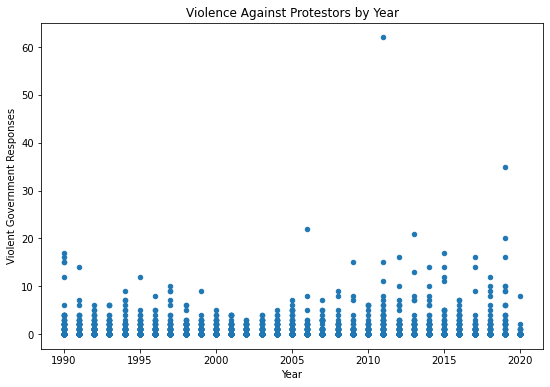

In [17]:
violence.plot(x="year", y="total_violence", kind="scatter", title="Violence Against Protestors by Year", xlabel="Year", ylabel="Violent Government Responses", figsize=((9, 6)))
plt.show()

The data seems very skewed towards low amounts of violence, with very little change over time. There does some to be some a somewhat-linear breakaway with more violence on the later half of the graph, but is this statistically signficant?

## Hypothesis Testing

 We can test that uses [Statsmodels's linear regression functionality](https://www.statsmodels.org/devel/regression.html). This library is not only able to perform a regression, but also calculates informative statistics for interpretation.

The statistic we are looking for to test significance is the p-value. This statistic tells us how likely it is that the Null Hypothesis explains the data that we see. In the case of a linear regression, the Null Hypothesis is that there is no relationship between two variables. The higher the p-value, the higher the harder it is the reject the Null Hypothesis

In order to prove an Alternative Hypothesis, in this case that there is a linear relationship between year and total state violence against protesters, a low enough p-value much be achieved to reject the Null Hypothesis. A standard p-value to use is 0.05, below which the Null Hypotehsis can be rejected. This will be the cutoff we will use throughout this project. 

For this question, our Null Hypothsis will be that there is no relationship will be that there is no relationship between year and state violence against protesters, while our Alternative Hypothesis will be there there is a linear relationship between the two variables. 

The regression will work best if we normalize the year to start at 0. 

In [18]:
violence["from_1990"] = violence["year"] - 1990
model = ols(formula="total_violence ~ from_1990", data=violence)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:         total_violence   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5022
Date:                Mon, 16 May 2022   Prob (F-statistic):              0.479
Time:                        19:55:54   Log-Likelihood:                -9952.6
No. Observations:                4876   AIC:                         1.991e+04
Df Residuals:                    4874   BIC:                         1.992e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4944      0.053      9.415      0.0

The p-value of the coefficient is given in the P>|t| column. For the relationship between year and violence, we see a p-value of about 0.479, well above our threshold to reject the Null Hypothesis. 

Our conclusion from this result is that there is not enough evidence to reject the Null Hypothesis, and so we cannot support the claim that there is a linear relationship between year and violence committed against protesters.

## Further Exploration

Data is not only collected on state violence, however. How about we look at protester violence across the years, using the same procedure as with state violence. Notice that this takes us back to the Data Exploration phase of our pipeline, even though we just finished our conclusions on our previous analysis. As previously stated, this is not a linear process, and we often find ourselves asking more questions that lead us back up the pipeline. 

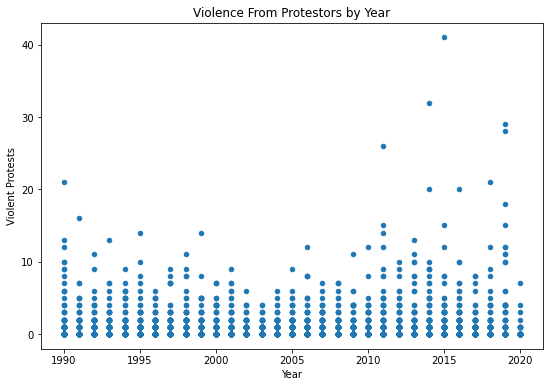

In [19]:
protester_violence = cleaned_protest.groupby(["country", "year"])[["protesterviolence"]].sum().reset_index()
protester_violence.plot(x="year", y="protesterviolence", kind="scatter", title="Violence From Protestors by Year", xlabel="Year", ylabel="Violent Protests", figsize=((9, 6)))
plt.show()

This graph is similar to the one we found for state violence, but has considerably more variance. It also seems to have a slight linear increase towards the end, but we must ask the same question again: is it significant?

Let's perform the same test again, this time with protester violence.

Null hypothesis - There is no relationship between year and violence from protesters

Alternative Hypothesis - There is a linear relationship between year and violence from protesters

Target p-value - 0.05

In [20]:
protester_violence["from_1990"] = protester_violence["year"] - 1990
model = ols(formula="protesterviolence ~ from_1990", data=protester_violence)
res = model.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:      protesterviolence   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.199
Date:                Mon, 16 May 2022   Prob (F-statistic):             0.0737
Time:                        19:55:55   Log-Likelihood:                -10403.
No. Observations:                4876   AIC:                         2.081e+04
Df Residuals:                    4874   BIC:                         2.082e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7388      0.058     12.827      0.0

This time, the p-value is much smaller at 0.074, but still above the threshold that we set. This does not mean that the Alternative Hypothesis is necessarily incorrect, however. Our acceptance or rejection of the Null Hypothesis is based on the arbitrary p-value we chose as our cutoff. In many studies, this value is much higher, and this result may be considered significant. 

What is important is that we did not change our p-value cutoff after seeing the results. This maintains the integrity of the test and ensures we are looking only for satisfactory evidence towards a conclusions, rather than a conclusion itself. 

speaking of conclusions, our here will once again be nulll: there is not enough evidence to reject the Null Hypothesis that there is no relationship between year and protestor violence. 

## Even More Exploration

We've asked questions about violence from both the state and protesters, but what is the relationship between the two? Let's try and visualize it with a barplot showing the frequency of one, both, or neither occuring at any protest. 

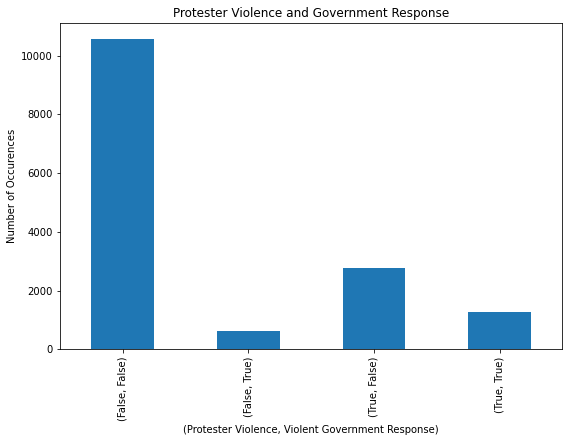

In [21]:

cleaned_protest["violent_response"] = cleaned_protest["beatings"] | cleaned_protest["shootings"] | cleaned_protest["killings"]

violence_start = pd.DataFrame(cleaned_protest.loc[cleaned_protest["protest"], ["protesterviolence", "violent_response"]].groupby("protesterviolence").value_counts())
violence_start.plot.bar(xlabel="(Protester Violence, Violent Government Response)", ylabel="Number of Occurences", title="Protester Violence and Government Response", figsize=(9,6), legend=False)
plt.show()

This chart shows that the overwhelming majority of protests contain no violence from either side. However, one interesting note is that state violence seems to be more likely if there is also protester violence. We can test whether there is a signficant difference between state violence with or without protester violence using an A/B test. An excellent guide on how to do this in Python can be found [here](https://towardsdatascience.com/ab-testing-with-python-e5964dd66143#4.-Testing-the-hypothesis)

An A/B test is meant to test whether adding some sort of change or "treatement" to a sample affects the sample in a statistically significant way. In our case, the "treatement" will be adding a violent protest, and we will test whether this significantly affects whether or not the state responds violently. To do this, we will need the total number of observations with and without protester violence, as well the number of observation with government violence and with or without protester violence. Using these values, Statsmodel's proportion_ztest function can calculation a p-value to test the significance of the relationship. 

As before, when we have a p-value it is very important to understand what our Null and Alternative Hypotheses are.

Null Hypothesis - There is not difference in state violence based on protester violence

Alternative Hypothesis - Protestor violence does impact the frequency of state violence

P-value threshold - 0.05

 

In [22]:
violence_start.rename(columns={0: "occurences"}, inplace=True)
violence_start = violence_start.reset_index()
violence_start.head()

,protesterviolence,violent_response,occurences
0,False,False,10575
1,False,True,629
2,True,False,2765
3,True,True,1270


In [23]:
no_pro = violence_start.loc[violence_start["protesterviolence"] == False, "occurences"].sum()
no_pro_gov = violence_start.loc[(violence_start["protesterviolence"] == False) & violence_start["violent_response"], "occurences"].iloc[0]
pro = violence_start.loc[violence_start["protesterviolence"], "occurences"].sum()
pro_gov = violence_start.loc[violence_start["protesterviolence"] & violence_start["violent_response"], "occurences"].iloc[0]

z_stat, p_val = proportions_ztest([no_pro_gov, pro_gov], nobs=[no_pro, pro])
print(z_stat, p_val)

-42.64651948960309 0.0


Here, we see a p-value near 0, indicating a very significant relationship between the two variables. This is well below our threshold, so it is safe for us to propose the Alternative Hypothesis. However, this is not necessarily proof for the Alternative Hypothesis, as all we have done is reject the Null Hypothesis. In this case, our Alternative Hypothesis is simply the opposite of the Null Hypothesis, and thus must be true, but this is not always in the case. 

In our previous example, if we had rejected the Null Hypothesis, this would not have proved a linear relationship, only disproved there not being any relationship. 

Nonetheless, all of this analysis does provide useful insights into global protests trends. The frequency of violence at protests from either side does not seem to have any significant change over time, and it seems that violence from the state often goes hand-and-hand with violence from protestors. 